# Using Keras Model Subclassing with the Eager mode

The tf.keras model subclassing mode is an alternative to the Sequential API. This is an exploration of its possibilities, with visualization on TensorBoard.

This is an example using the MNIST classification problem.

In [1]:
from IPython.display import Image

First we enable the eager execution

In [2]:
import tensorflow as tf
tf.enable_eager_execution()
tfe = tf.contrib.eager
import numpy as np

/Users/maxime/anaconda2/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/maxime/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 1. Using a Linear Model

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

We use a batch size of 100.

In [4]:
buffer_size = 5000
batch_size = 100

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size)
train_dataset = train_dataset.batch(batch_size)

This defines our model, with a call function that flattens our input and passes it through 1 layer.

In [5]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense_1 = tf.keras.layers.Dense(10)

    def call(self, x):
        x = self.flatten(x)
        return self.dense_1(x) # returns logits

In [6]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

These functions compute loss, accuracy of the model

In [7]:
def loss(logits, labels):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = labels)

In [8]:
def compute_accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1)
    batch_size = int(logits.shape[0])
    return tf.reduce_sum(
      tf.cast(tf.equal(predictions, labels), dtype=tf.float32)) / batch_size

Here, we train the model for a set of (images, labels)

In [9]:
def train(model, images, labels):
    with tf.GradientTape() as tape:
        logits = model(images)
        loss_value = loss(logits, labels)  
        grads = tape.gradient(loss_value, model.variables)
        optimizer.apply_gradients(zip(grads, model.variables))
    return loss_value

This writer saves our results in a log to be visualized with TensoBoard

In [10]:
writer = tf.contrib.summary.create_file_writer(logdir="TB/LinearModel", flush_millis=1000)

This loops through thhe batch for each epoch

In [11]:
model = Model()

epochs = 10
step_counter = 0

with writer.as_default():
    with tf.contrib.summary.always_record_summaries():
        for epoch_n in range(epochs):
            print('Epoch #%d' % (epoch_n))
            for (batch, (images, labels)) in enumerate(train_dataset):
                loss_value = train(model, images, labels)
                step_counter +=1
                tf.contrib.summary.scalar("loss",np.mean(loss_value), step = step_counter)
  
                if step_counter % 100 == 0:
                    print('Step #%d\tLoss: %.4f' % (step_counter, np.mean(loss_value)))

            test_accuracy = compute_accuracy(model(x_test), y_test)
            print('Accuracy #%.2f\n' % (test_accuracy))

writer.close()

Epoch #0
Step #100	Loss: 1.3159
Step #200	Loss: 0.5923
Step #300	Loss: 1.1667
Step #400	Loss: 2.4172
Step #500	Loss: 2.7146
Step #600	Loss: 4.2100
Accuracy #0.85

Epoch #1
Step #700	Loss: 0.7627
Step #800	Loss: 3.0632
Step #900	Loss: 2.8098
Step #1000	Loss: 1.4548
Step #1100	Loss: 1.7061
Step #1200	Loss: 0.5720
Accuracy #0.90

Epoch #2
Step #1300	Loss: 1.1397
Step #1400	Loss: 1.5996
Step #1500	Loss: 1.6870
Step #1600	Loss: 1.1863
Step #1700	Loss: 1.0698
Step #1800	Loss: 1.2452
Accuracy #0.91

Epoch #3
Step #1900	Loss: 2.2860
Step #2000	Loss: 3.4498
Step #2100	Loss: 2.2702
Step #2200	Loss: 1.9232
Step #2300	Loss: 1.7680
Step #2400	Loss: 1.3358
Accuracy #0.90

Epoch #4
Step #2500	Loss: 1.6548
Step #2600	Loss: 0.4607
Step #2700	Loss: 2.1500
Step #2800	Loss: 1.5270
Step #2900	Loss: 1.7986
Step #3000	Loss: 0.9858
Accuracy #0.84

Epoch #5
Step #3100	Loss: 3.6111
Step #3200	Loss: 2.1119
Step #3300	Loss: 1.7709
Step #3400	Loss: 1.2849
Step #3500	Loss: 0.4806
Step #3600	Loss: 2.7607
Accuracy #0

This is the loss output in Tensorboard

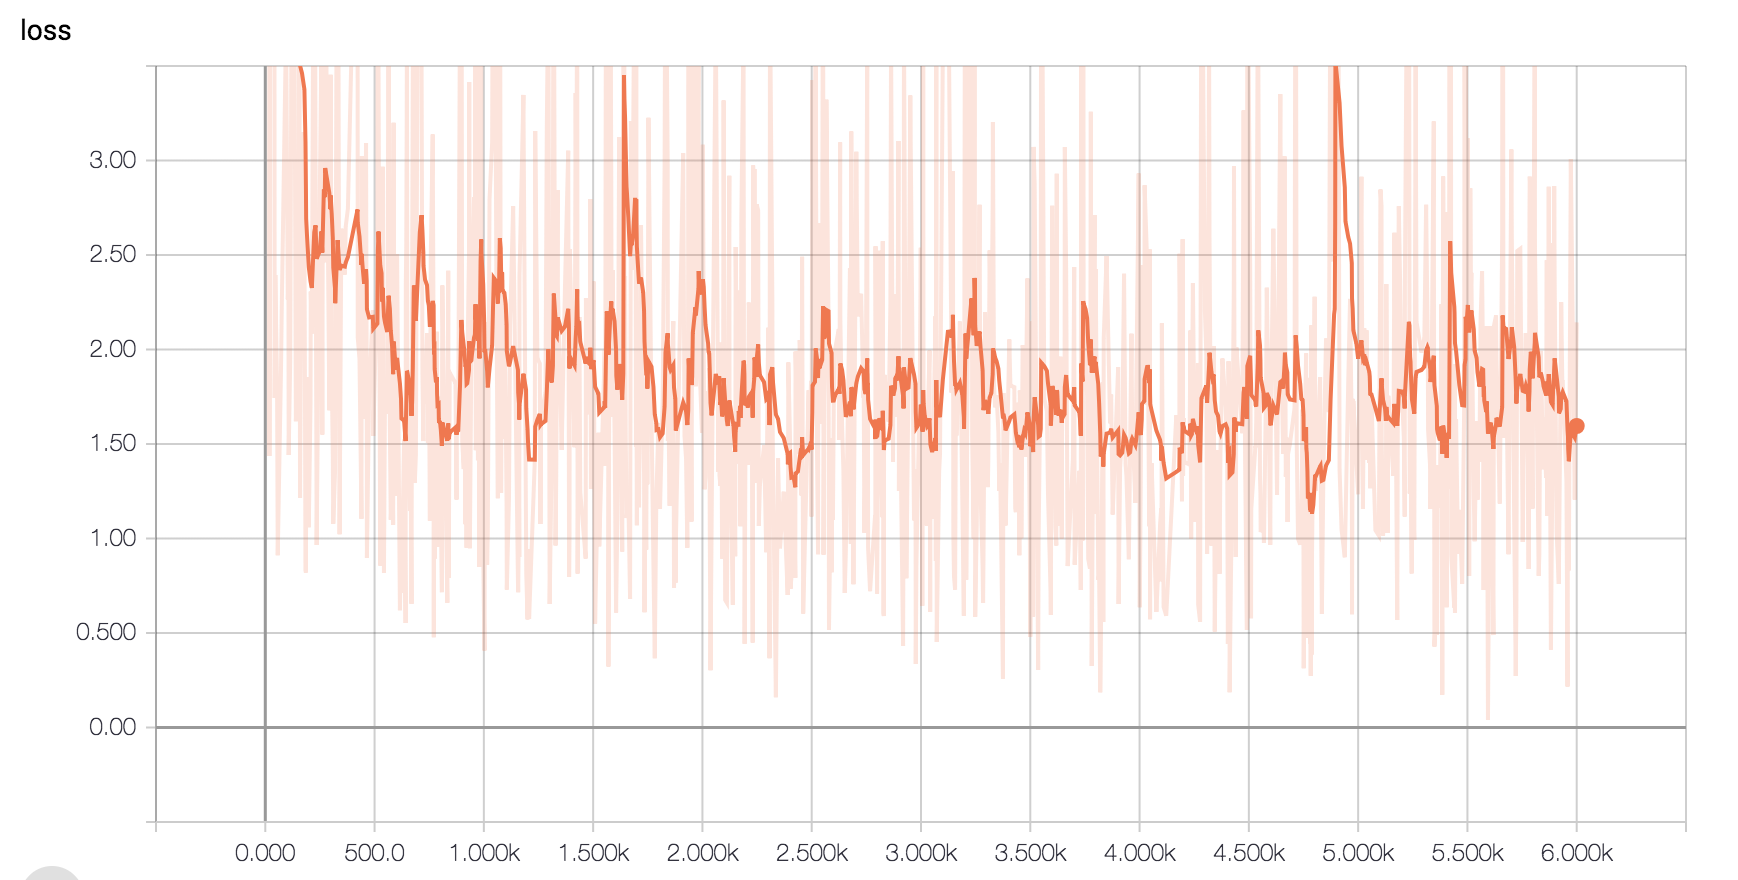

In [40]:
Image("Screenshots_TB/LossLinearModel.png")
# Loss For the Linear Model

# 2. Using a Dense NN

In [12]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)

In [13]:
#Here we add hidden layers
class Model1(tf.keras.Model):
    def __init__(self):
        super(Model1, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense_1 = tf.keras.layers.Dense(512, activation=tf.nn.relu)
        self.dense_2 = tf.keras.layers.Dense(512, activation=tf.nn.relu)
        self.dense_3 = tf.keras.layers.Dense(10)

    def call(self, x):
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.dense_3(x) 

In [14]:
writer = tf.contrib.summary.create_file_writer(logdir="TB/DeepNeuralNetwork", flush_millis=1000)

In [15]:

model = Model1()

epochs = 10
step_counter = 0

with writer.as_default():
    with tf.contrib.summary.always_record_summaries():
        for epoch_n in range(epochs):
            print('Epoch #%d' % (epoch_n))
            for (batch, (images, labels)) in enumerate(train_dataset):
                loss_value = train(model, images, labels)
                step_counter +=1
                tf.contrib.summary.scalar("loss",np.mean(loss_value), step = step_counter)
  
                if step_counter % 100 == 0:
                    print('Step #%d\tLoss: %.4f' % (step_counter, np.mean(loss_value)))

            test_accuracy = compute_accuracy(model(x_test), y_test)
            print('Accuracy #%.2f\n' % (test_accuracy))

writer.close()

Epoch #0
Step #100	Loss: 0.5258
Step #200	Loss: 0.2036
Step #300	Loss: 0.5033
Step #400	Loss: 0.2574
Step #500	Loss: 0.2624
Step #600	Loss: 0.2940
Accuracy #0.94

Epoch #1
Step #700	Loss: 0.3385
Step #800	Loss: 0.2192
Step #900	Loss: 0.0808
Step #1000	Loss: 0.1175
Step #1100	Loss: 0.1153
Step #1200	Loss: 0.1921
Accuracy #0.96

Epoch #2
Step #1300	Loss: 0.1293
Step #1400	Loss: 0.1171
Step #1500	Loss: 0.1358
Step #1600	Loss: 0.1723
Step #1700	Loss: 0.1280
Step #1800	Loss: 0.0477
Accuracy #0.97

Epoch #3
Step #1900	Loss: 0.1205
Step #2000	Loss: 0.0884
Step #2100	Loss: 0.1158
Step #2200	Loss: 0.0924
Step #2300	Loss: 0.0667
Step #2400	Loss: 0.1256
Accuracy #0.97

Epoch #4
Step #2500	Loss: 0.1382
Step #2600	Loss: 0.0293
Step #2700	Loss: 0.0402
Step #2800	Loss: 0.0427
Step #2900	Loss: 0.0346
Step #3000	Loss: 0.1163
Accuracy #0.97

Epoch #5
Step #3100	Loss: 0.0563
Step #3200	Loss: 0.0120
Step #3300	Loss: 0.0431
Step #3400	Loss: 0.0353
Step #3500	Loss: 0.0789
Step #3600	Loss: 0.0209
Accuracy #0

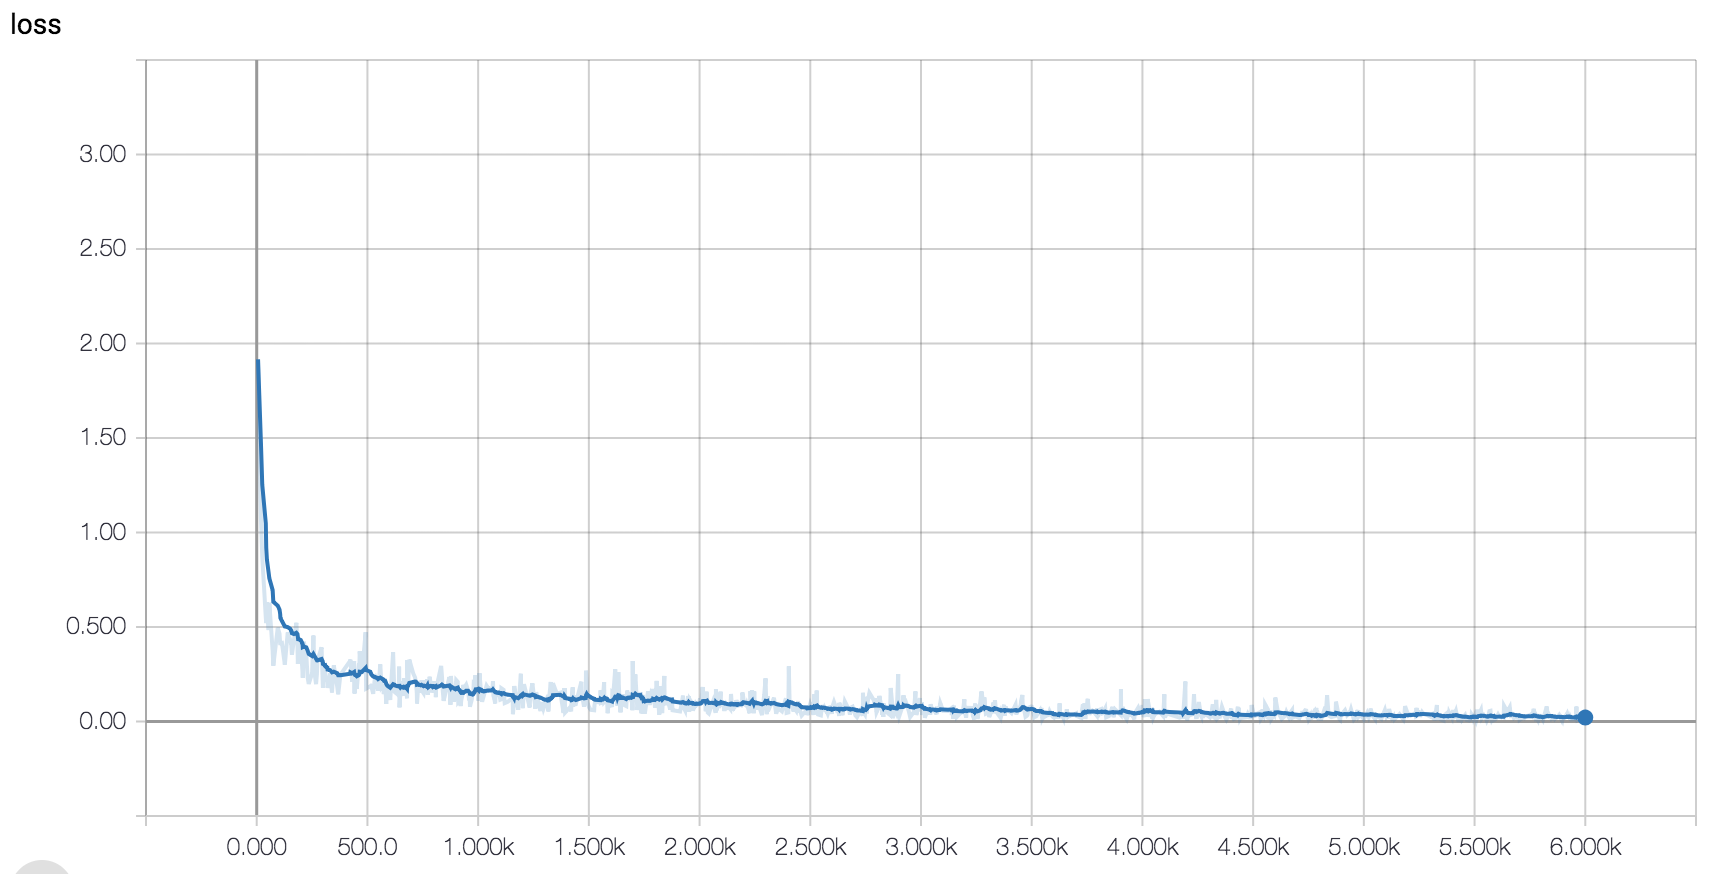

In [41]:
Image("Screenshots_TB/LossDeepNeuralNetwork.png")
# Loss For the Deep NN Model

Using the DNN allows us to reduce the loss. We can try to see what happens to our model now when tuning other parameters.

# 3. Playing with learning rates

The learning rate defines the step size in the optimization of our weights. Increasing it makes it faster, but also less precise

In [16]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

In [17]:
writer = tf.contrib.summary.create_file_writer(logdir="TB/HighLearningRate", flush_millis=1000)

In [18]:


model = Model1()

epochs = 10
step_counter = 0

with writer.as_default():
    with tf.contrib.summary.always_record_summaries():
        for epoch_n in range(epochs):
            print('Epoch #%d' % (epoch_n))
            for (batch, (images, labels)) in enumerate(train_dataset):
                loss_value = train(model, images, labels)
                step_counter +=1
                tf.contrib.summary.scalar("loss",np.mean(loss_value), step = step_counter)
  
                if step_counter % 100 == 0:
                    print('Step #%d\tLoss: %.4f' % (step_counter, np.mean(loss_value)))

            test_accuracy = compute_accuracy(model(x_test), y_test)
            print('Accuracy #%.2f\n' % (test_accuracy))

writer.close()

Epoch #0
Step #100	Loss: 2.4282
Step #200	Loss: 2.2631
Step #300	Loss: 2.3198
Step #400	Loss: 2.3788
Step #500	Loss: 2.3551
Step #600	Loss: 2.3679
Accuracy #0.11

Epoch #1
Step #700	Loss: 2.3203
Step #800	Loss: 2.3155
Step #900	Loss: 2.3964
Step #1000	Loss: 2.3152
Step #1100	Loss: 2.3149
Step #1200	Loss: 2.3455
Accuracy #0.09

Epoch #2
Step #1300	Loss: 2.3501
Step #1400	Loss: 2.3433
Step #1500	Loss: 2.3121
Step #1600	Loss: 2.4347
Step #1700	Loss: 2.3692
Step #1800	Loss: 2.3798
Accuracy #0.10

Epoch #3
Step #1900	Loss: 2.3447
Step #2000	Loss: 2.3187
Step #2100	Loss: 2.3446
Step #2200	Loss: 2.3368
Step #2300	Loss: 2.3211
Step #2400	Loss: 2.2932
Accuracy #0.10

Epoch #4
Step #2500	Loss: 2.3900
Step #2600	Loss: 2.4404
Step #2700	Loss: 2.3815
Step #2800	Loss: 2.2992
Step #2900	Loss: 2.3579
Step #3000	Loss: 2.3352
Accuracy #0.10

Epoch #5
Step #3100	Loss: 2.3058
Step #3200	Loss: 2.3190
Step #3300	Loss: 2.3568
Step #3400	Loss: 2.4293
Step #3500	Loss: 2.3970
Step #3600	Loss: 2.3424
Accuracy #0

This model is not able to learn anything, because the learning rate is too large

In [19]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.00001)

In [20]:
writer = tf.contrib.summary.create_file_writer(logdir="TB/LowLearningRate", flush_millis=1000)

In [21]:


model = Model1()

epochs = 10
step_counter = 0

with writer.as_default():
    with tf.contrib.summary.always_record_summaries():
        for epoch_n in range(epochs):
            print('Epoch #%d' % (epoch_n))
            for (batch, (images, labels)) in enumerate(train_dataset):
                loss_value = train(model, images, labels)
                step_counter +=1
                #tf.contrib.summary.scalar('loss',np.mean(loss_value))
                tf.contrib.summary.scalar("loss",np.mean(loss_value), step = step_counter)
  
                if step_counter % 100 == 0:
                    print('Step #%d\tLoss: %.4f' % (step_counter, np.mean(loss_value)))

            test_accuracy = compute_accuracy(model(x_test), y_test)
            print('Accuracy #%.2f\n' % (test_accuracy))

writer.close()

Epoch #0
Step #100	Loss: 2.2479
Step #200	Loss: 2.1848
Step #300	Loss: 2.1044
Step #400	Loss: 2.0696
Step #500	Loss: 1.9733
Step #600	Loss: 1.8860
Accuracy #0.63

Epoch #1
Step #700	Loss: 1.8057
Step #800	Loss: 1.7511
Step #900	Loss: 1.7022
Step #1000	Loss: 1.6397
Step #1100	Loss: 1.5469
Step #1200	Loss: 1.4545
Accuracy #0.76

Epoch #2
Step #1300	Loss: 1.4640
Step #1400	Loss: 1.3815
Step #1500	Loss: 1.3945
Step #1600	Loss: 1.3593
Step #1700	Loss: 1.2622
Step #1800	Loss: 1.1177
Accuracy #0.80

Epoch #3
Step #1900	Loss: 1.0720
Step #2000	Loss: 1.0564
Step #2100	Loss: 1.0821
Step #2200	Loss: 0.9589
Step #2300	Loss: 1.0310
Step #2400	Loss: 0.8905
Accuracy #0.83

Epoch #4
Step #2500	Loss: 0.8946
Step #2600	Loss: 0.9012
Step #2700	Loss: 0.8427
Step #2800	Loss: 0.8479
Step #2900	Loss: 0.7196
Step #3000	Loss: 0.6968
Accuracy #0.85

Epoch #5
Step #3100	Loss: 0.7430
Step #3200	Loss: 0.8335
Step #3300	Loss: 0.7687
Step #3400	Loss: 0.7739
Step #3500	Loss: 0.5947
Step #3600	Loss: 0.6084
Accuracy #0

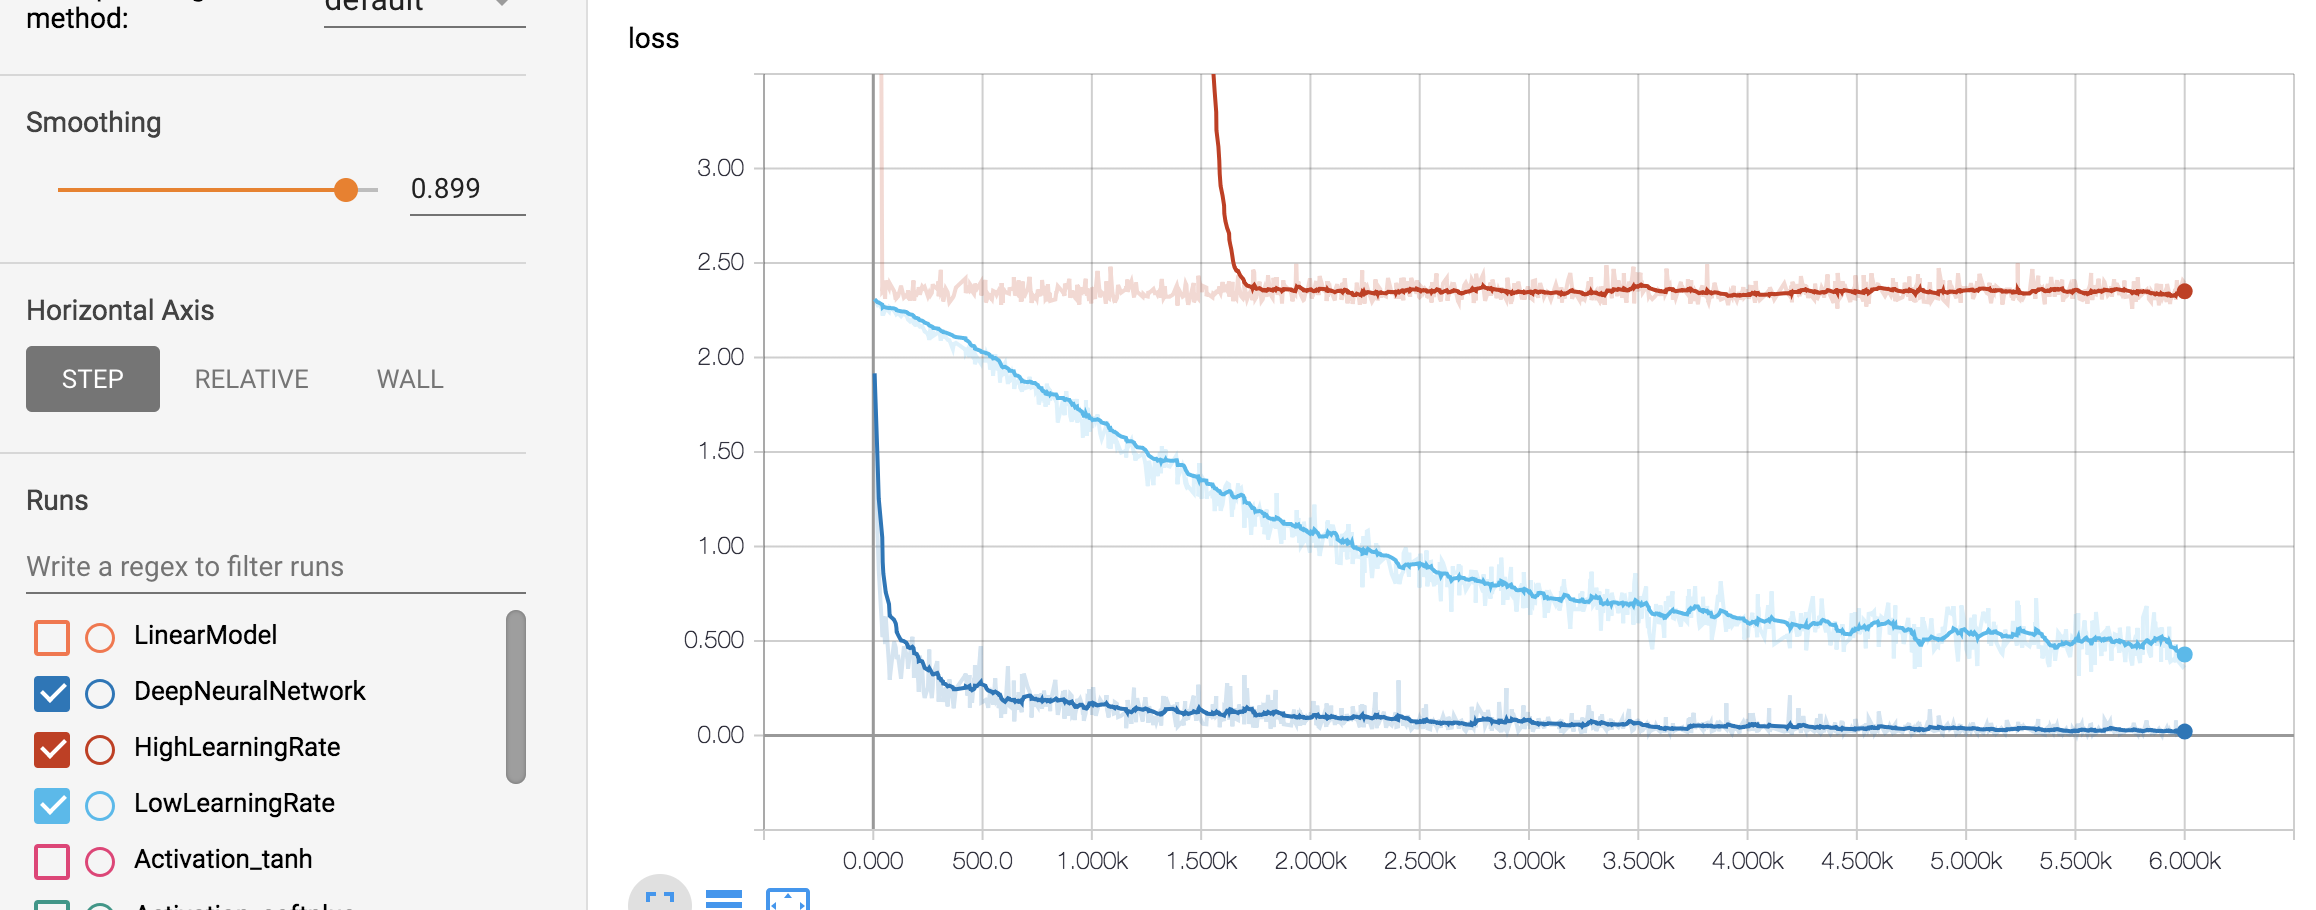

In [42]:
Image("Screenshots_TB/LossLearningRate.png")
# Loss For different Learning Rates

# 4. Using different activation functions

In [22]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)

What if choose different activation functions from relu?

In [23]:
class Model2(tf.keras.Model):
    def __init__(self):
        super(Model2, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense_1 = tf.keras.layers.Dense(512, activation=tf.nn.tanh)
        self.dense_2 = tf.keras.layers.Dense(512, activation=tf.nn.tanh)
        self.dense_3 = tf.keras.layers.Dense(10)

    def call(self, x):
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.dense_3(x) 

In [24]:
writer = tf.contrib.summary.create_file_writer(logdir="TB/Activation_tanh", flush_millis=1000)

In [25]:

model = Model2()

epochs = 10
step_counter = 0

with writer.as_default():
    with tf.contrib.summary.always_record_summaries():
        for epoch_n in range(epochs):
            print('Epoch #%d' % (epoch_n))
            for (batch, (images, labels)) in enumerate(train_dataset):
                loss_value = train(model, images, labels)
                step_counter +=1
                tf.contrib.summary.scalar("loss",np.mean(loss_value), step = step_counter)
  
                if step_counter % 100 == 0:
                    print('Step #%d\tLoss: %.4f' % (step_counter, np.mean(loss_value)))

            test_accuracy = compute_accuracy(model(x_test), y_test)
            print('Accuracy #%.2f\n' % (test_accuracy))

writer.close()

Epoch #0
Step #100	Loss: 0.4090
Step #200	Loss: 0.4036
Step #300	Loss: 0.1181
Step #400	Loss: 0.3018
Step #500	Loss: 0.3238
Step #600	Loss: 0.2850
Accuracy #0.92

Epoch #1
Step #700	Loss: 0.1724
Step #800	Loss: 0.1247
Step #900	Loss: 0.3167
Step #1000	Loss: 0.2006
Step #1100	Loss: 0.1759
Step #1200	Loss: 0.1393
Accuracy #0.94

Epoch #2
Step #1300	Loss: 0.3932
Step #1400	Loss: 0.3872
Step #1500	Loss: 0.2543
Step #1600	Loss: 0.1196
Step #1700	Loss: 0.2535
Step #1800	Loss: 0.2959
Accuracy #0.95

Epoch #3
Step #1900	Loss: 0.2167
Step #2000	Loss: 0.1814
Step #2100	Loss: 0.1918
Step #2200	Loss: 0.1010
Step #2300	Loss: 0.0913
Step #2400	Loss: 0.1674
Accuracy #0.96

Epoch #4
Step #2500	Loss: 0.0879
Step #2600	Loss: 0.0757
Step #2700	Loss: 0.1583
Step #2800	Loss: 0.1295
Step #2900	Loss: 0.2173
Step #3000	Loss: 0.1212
Accuracy #0.96

Epoch #5
Step #3100	Loss: 0.0892
Step #3200	Loss: 0.1070
Step #3300	Loss: 0.1116
Step #3400	Loss: 0.2570
Step #3500	Loss: 0.1953
Step #3600	Loss: 0.0347
Accuracy #0

In [26]:
class Model3(tf.keras.Model):
    def __init__(self):
        super(Model3, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense_1 = tf.keras.layers.Dense(512, activation=tf.nn.softplus)
        self.dense_2 = tf.keras.layers.Dense(512, activation=tf.nn.softplus)
        self.dense_3 = tf.keras.layers.Dense(10)

    def call(self, x):
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.dense_3(x) 

In [27]:
writer = tf.contrib.summary.create_file_writer(logdir="TB/Activation_softplus", flush_millis=1000)

In [28]:

model = Model3()

epochs = 10
step_counter = 0

with writer.as_default():
    with tf.contrib.summary.always_record_summaries():
        for epoch_n in range(epochs):
            print('Epoch #%d' % (epoch_n))
            for (batch, (images, labels)) in enumerate(train_dataset):
                loss_value = train(model, images, labels)
                step_counter +=1
                tf.contrib.summary.scalar("loss",np.mean(loss_value), step = step_counter)
  
                if step_counter % 100 == 0:
                    print('Step #%d\tLoss: %.4f' % (step_counter, np.mean(loss_value)))

            test_accuracy = compute_accuracy(model(x_test), y_test)
            print('Accuracy #%.2f\n' % (test_accuracy))

writer.close()

Epoch #0
Step #100	Loss: 1.1596
Step #200	Loss: 0.6016
Step #300	Loss: 0.4195
Step #400	Loss: 0.5024
Step #500	Loss: 0.3285
Step #600	Loss: 0.4012
Accuracy #0.89

Epoch #1
Step #700	Loss: 0.4015
Step #800	Loss: 0.3301
Step #900	Loss: 0.2825
Step #1000	Loss: 0.3714
Step #1100	Loss: 0.2624
Step #1200	Loss: 0.1506
Accuracy #0.92

Epoch #2
Step #1300	Loss: 0.2025
Step #1400	Loss: 0.4400
Step #1500	Loss: 0.3186
Step #1600	Loss: 0.2133
Step #1700	Loss: 0.3587
Step #1800	Loss: 0.2127
Accuracy #0.92

Epoch #3
Step #1900	Loss: 0.1454
Step #2000	Loss: 0.2654
Step #2100	Loss: 0.2356
Step #2200	Loss: 0.3204
Step #2300	Loss: 0.2403
Step #2400	Loss: 0.1104
Accuracy #0.93

Epoch #4
Step #2500	Loss: 0.3513
Step #2600	Loss: 0.1247
Step #2700	Loss: 0.1705
Step #2800	Loss: 0.1604
Step #2900	Loss: 0.3306
Step #3000	Loss: 0.2015
Accuracy #0.94

Epoch #5
Step #3100	Loss: 0.3714
Step #3200	Loss: 0.1897
Step #3300	Loss: 0.2564
Step #3400	Loss: 0.1952
Step #3500	Loss: 0.2096
Step #3600	Loss: 0.3208
Accuracy #0

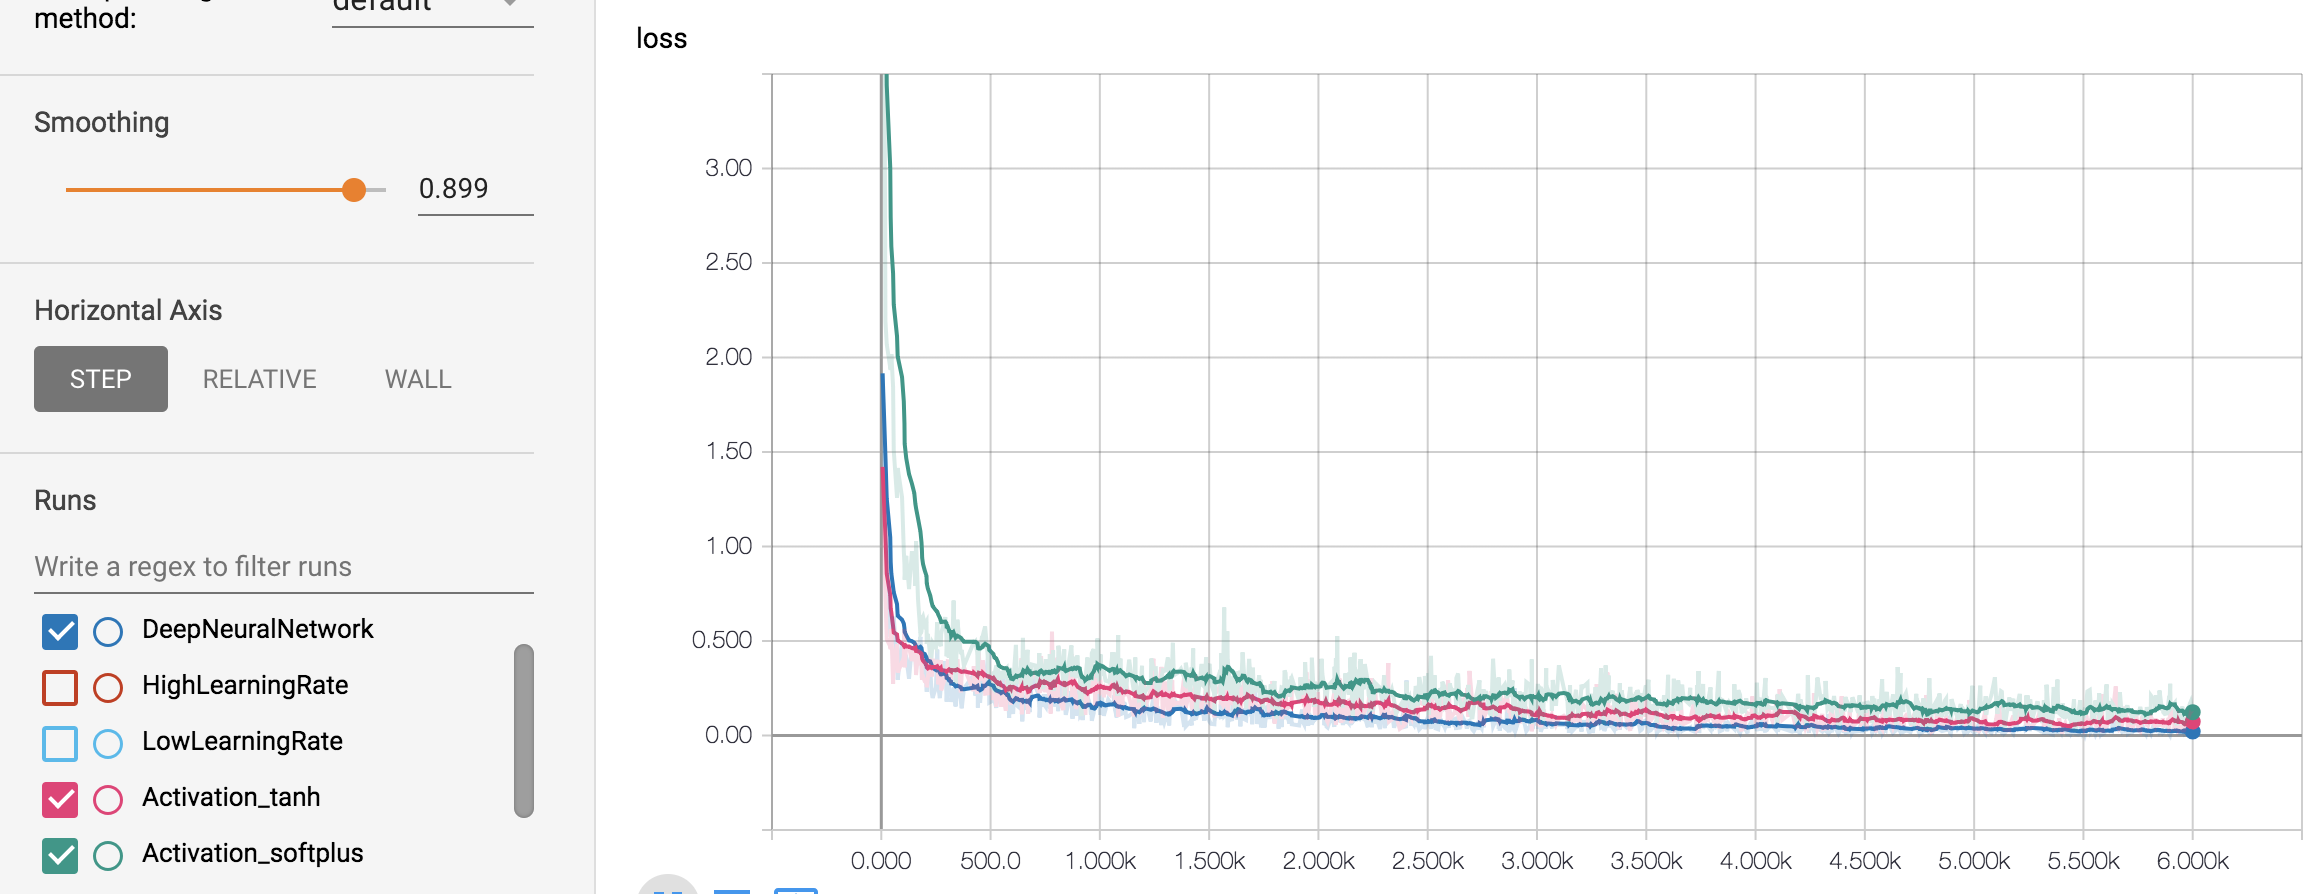

In [43]:
Image("Screenshots_TB/LossActivation.png")
# Loss For the different Activation Functions

As we can see, relu seems to work slightly better than softplus and tanh.

# 5. Using different gradient descent algorithms

In [29]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

In [30]:
writer = tf.contrib.summary.create_file_writer(logdir="TB/Optimizer_adam", flush_millis=1000)

In [31]:

model = Model1()

epochs = 10
step_counter = 0

with writer.as_default():
    with tf.contrib.summary.always_record_summaries():
        for epoch_n in range(epochs):
            print('Epoch #%d' % (epoch_n))
            for (batch, (images, labels)) in enumerate(train_dataset):
                loss_value = train(model, images, labels)
                step_counter +=1
                tf.contrib.summary.scalar("loss",np.mean(loss_value), step = step_counter)
  
                if step_counter % 100 == 0:
                    print('Step #%d\tLoss: %.4f' % (step_counter, np.mean(loss_value)))

            test_accuracy = compute_accuracy(model(x_test), y_test)
            print('Accuracy #%.2f\n' % (test_accuracy))

writer.close()

Epoch #0
Step #100	Loss: 0.2524
Step #200	Loss: 0.2668
Step #300	Loss: 0.2491
Step #400	Loss: 0.1709
Step #500	Loss: 0.1504
Step #600	Loss: 0.1978
Accuracy #0.97

Epoch #1
Step #700	Loss: 0.0269
Step #800	Loss: 0.0274
Step #900	Loss: 0.0692
Step #1000	Loss: 0.0698
Step #1100	Loss: 0.0310
Step #1200	Loss: 0.0205
Accuracy #0.98

Epoch #2
Step #1300	Loss: 0.0336
Step #1400	Loss: 0.0260
Step #1500	Loss: 0.0334
Step #1600	Loss: 0.0186
Step #1700	Loss: 0.0188
Step #1800	Loss: 0.0458
Accuracy #0.98

Epoch #3
Step #1900	Loss: 0.0308
Step #2000	Loss: 0.1086
Step #2100	Loss: 0.0247
Step #2200	Loss: 0.0489
Step #2300	Loss: 0.0227
Step #2400	Loss: 0.0153
Accuracy #0.98

Epoch #4
Step #2500	Loss: 0.0476
Step #2600	Loss: 0.0270
Step #2700	Loss: 0.0203
Step #2800	Loss: 0.0894
Step #2900	Loss: 0.0591
Step #3000	Loss: 0.1426
Accuracy #0.97

Epoch #5
Step #3100	Loss: 0.0394
Step #3200	Loss: 0.0119
Step #3300	Loss: 0.0408
Step #3400	Loss: 0.0093
Step #3500	Loss: 0.0133
Step #3600	Loss: 0.0063
Accuracy #0

In [32]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)

In [33]:
writer = tf.contrib.summary.create_file_writer(logdir="TB/Optimizer_RMSprop", flush_millis=1000)

In [34]:

model = Model1()

epochs = 10
step_counter = 0

with writer.as_default():
    with tf.contrib.summary.always_record_summaries():
        for epoch_n in range(epochs):
            print('Epoch #%d' % (epoch_n))
            for (batch, (images, labels)) in enumerate(train_dataset):
                loss_value = train(model, images, labels)
                step_counter +=1
                tf.contrib.summary.scalar("loss",np.mean(loss_value), step = step_counter)
  
                if step_counter % 100 == 0:
                    print('Step #%d\tLoss: %.4f' % (step_counter, np.mean(loss_value)))

            test_accuracy = compute_accuracy(model(x_test), y_test)
            print('Accuracy #%.2f\n' % (test_accuracy))

writer.close()

Epoch #0
Step #100	Loss: 0.2263
Step #200	Loss: 0.2073
Step #300	Loss: 0.2204
Step #400	Loss: 0.1465
Step #500	Loss: 0.0998
Step #600	Loss: 0.0938
Accuracy #0.96

Epoch #1
Step #700	Loss: 0.0701
Step #800	Loss: 0.0595
Step #900	Loss: 0.0461
Step #1000	Loss: 0.1130
Step #1100	Loss: 0.0873
Step #1200	Loss: 0.0545
Accuracy #0.97

Epoch #2
Step #1300	Loss: 0.0278
Step #1400	Loss: 0.0271
Step #1500	Loss: 0.0665
Step #1600	Loss: 0.0624
Step #1700	Loss: 0.0552
Step #1800	Loss: 0.0718
Accuracy #0.97

Epoch #3
Step #1900	Loss: 0.0106
Step #2000	Loss: 0.0390
Step #2100	Loss: 0.0205
Step #2200	Loss: 0.0510
Step #2300	Loss: 0.0558
Step #2400	Loss: 0.0697
Accuracy #0.98

Epoch #4
Step #2500	Loss: 0.1182
Step #2600	Loss: 0.0282
Step #2700	Loss: 0.0342
Step #2800	Loss: 0.0113
Step #2900	Loss: 0.0398
Step #3000	Loss: 0.0850
Accuracy #0.97

Epoch #5
Step #3100	Loss: 0.0172
Step #3200	Loss: 0.0038
Step #3300	Loss: 0.0065
Step #3400	Loss: 0.0017
Step #3500	Loss: 0.0290
Step #3600	Loss: 0.0017
Accuracy #0

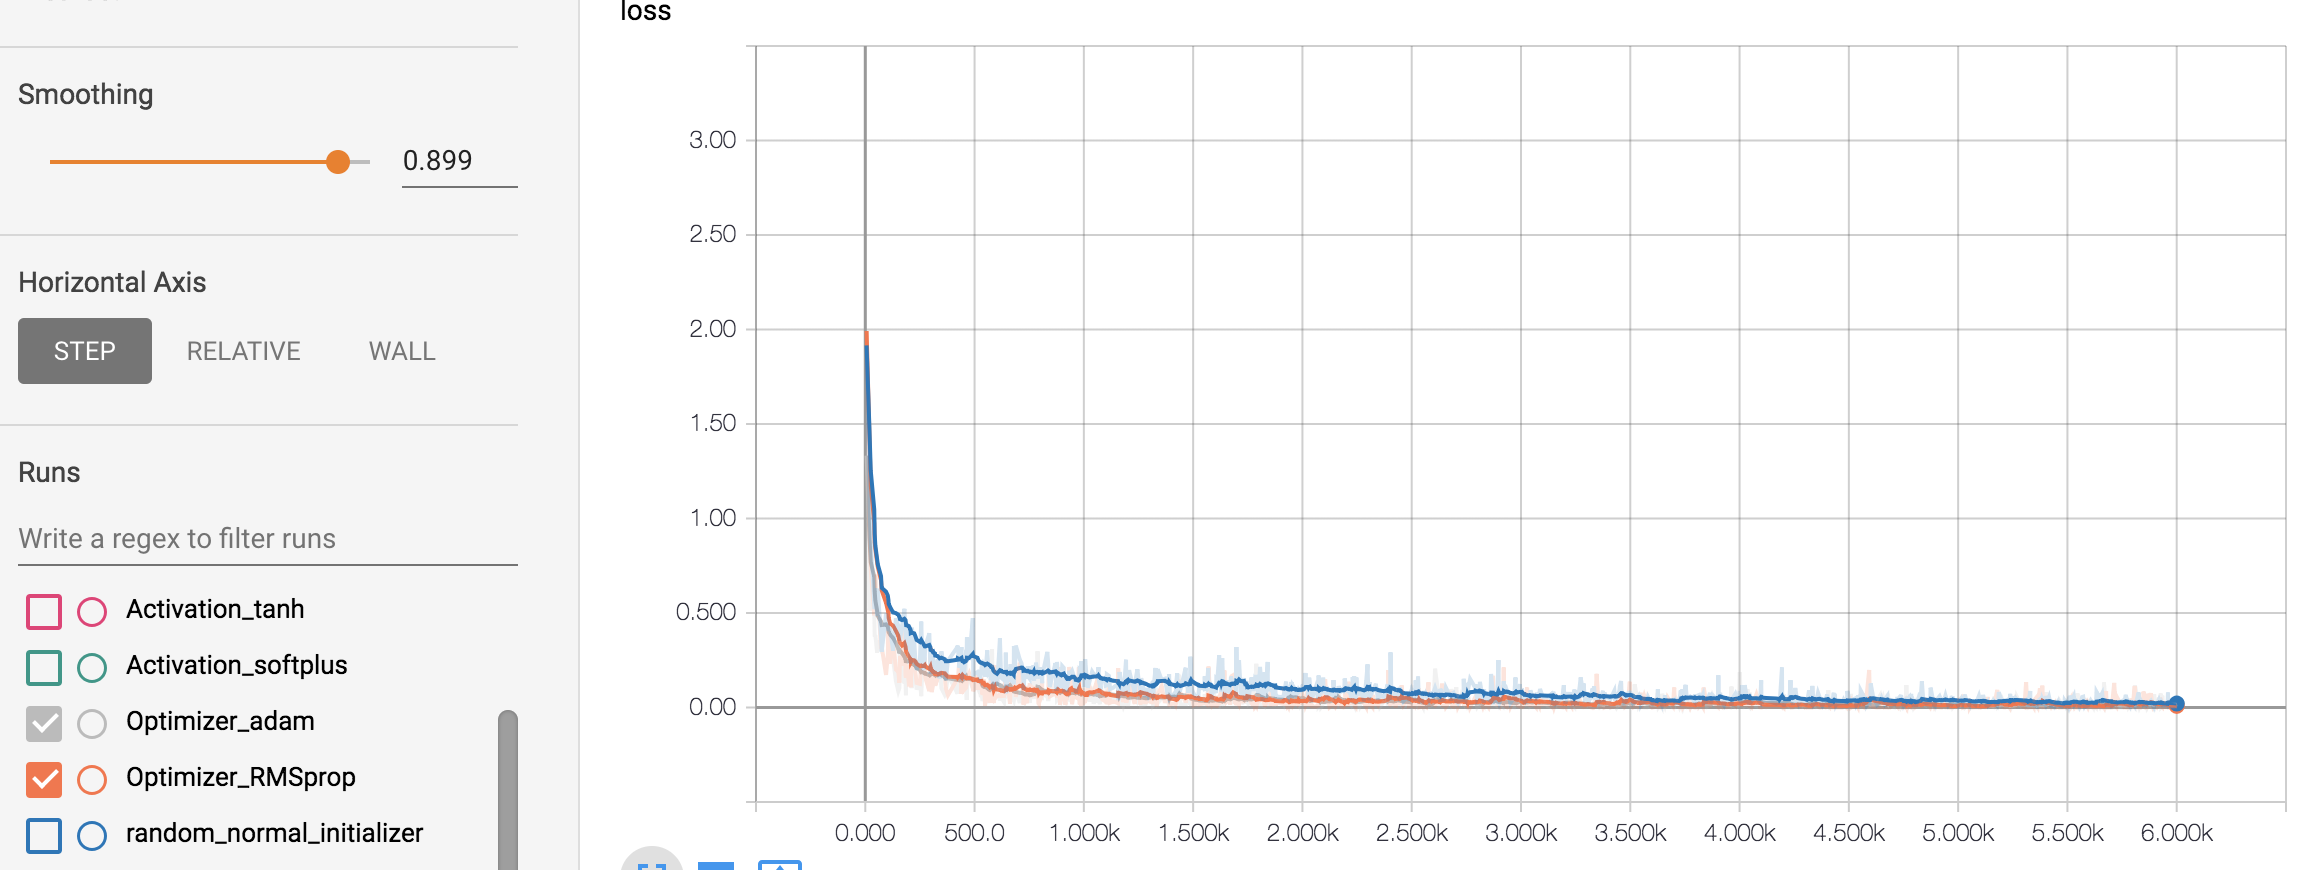

In [44]:
Image("Screenshots_TB/LossOptimizer.png")
# Loss For different Optimizers

# Summary findings

* The Deep NN has a much larger accuracy than the Linear Model

* 0.001 as a Learning Rate seems to be ideal. A higher Learning Rate prevents the model from learning anything, whereas a lower learning rate makes it much slower to learn

* For activation functions, the difference for this dataset is not extremely high, given that they all perform well. However, relu seems to be more accurate than tanh, which seems to be more accurate than softplus

* For optimizer algorithms, the difference in accuracy is even smaller. Still, we can see that Adam or RMSProp would both be better choices than GradientDescentOptimizer

* As far as the weight initialization is concerned, it does not look like it plays a very important role for this particular problem